# General Algorithm For Course (version 0.1)
1. Remove essential nodes and clean up network
2. Perform Markov Cluster Algorithm (MCL) setting numnodes in the nieghbourhood of 200/300. 
3. Create new network, where each node represents the clusters:
  - Weighted network option with weights set to number of connections between cluster a and cluster b
  - Unweighted set by direct connection.
4. Perform centrality analysis on the cluster network and identify important clusters.
5. Find shortest path nodes for important clusters as proteins of inteerest.

In [1]:
import networkx as nx
import markov_clustering as mc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd



In [4]:
df = pd.read_csv("network_info/4932_protein_links_v11_5.txt", sep=" ")
nodes = set(df["protein1"])

df = df[df.combined_score >= 700]
G = nx.from_pandas_edgelist(df, "protein1", "protein2")

new = nodes - set(G.nodes)
for node in new:
    G.add_node(node)
    
essential = pd.read_csv("network_info/essential_proteins.csv", header = None, usecols = [1])
essential = essential[1].tolist()

for protein in essential:
    name = "4932." + protein
    if name in G.nodes():
        G.remove_node(name)
        

In [6]:
#Finds clusters
adj_matrix = nx.adjacency_matrix(G) # Here we are going to lose the protein names as the matrix gets assigned to their index. So we recover that with a hash table
# Create a hash table that takes takes a number and returns a protein name
protein_hash = {}
for index, node in enumerate(G.nodes):
    protein_hash[index] = node

/var/folders/qm/5krpz0vd1n5g2tknvt69wkx00000gn/T/ipykernel_63262/2274313564.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G) # Here we are going to lose the protein names as the matrix gets assigned to their index. So we recover that with a hash table


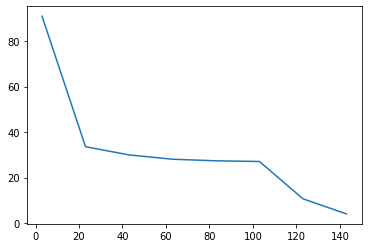

In [ ]:
# CAUTION TAKES A LONG TIME TO RUN
def getmeans(expansion,inflation):
    ''' This function takes the imputs of expansion and inflation for the MCL algorithm. Then it returns the mean size of the length of each cluster after the algorithm'''
    result = mc.run_mcl(adj_matrix,expansion=expansion,inflation=inflation)
    clusters = mc.get_clusters(result) 
    clusterlengths = [len(cluster) for cluster in clusters]
    return sum(clusterlengths)/len(clusterlengths)

# Range of test inflation values for fixed expansion = 5
inflations = range(3,163,20)
means = [getmeans(3,inflation) for inflation in inflations]

plt.plot(inflations,means)
plt.xlabel("Inflation Value");
plt.ylabel("Mean Cluster Size")


In [ ]:
print(getmeans(3,120))

18.791666666666668


In [7]:
EXPANSION = 3
INFLATION = 120
result = mc.run_mcl(adj_matrix,expansion=EXPANSION,inflation=INFLATION)
clusters = mc.get_clusters(result) 

In [ ]:
print(f"The number of clusters: {len(clusters)}")
print(f"Number of proteins: {sum(len(cluster) for cluster in clusters)}")
print(f"Average size of cluster: {round(sum(len(cluster) for cluster in clusters)/len(clusters),3)} nodes")

In [8]:
named_clusters = []
lpd1pos = 0
for index,cluster in enumerate(clusters):
    named_cluster = tuple([protein_hash[node] for node in cluster])
    if "4932.YFL018C" in named_cluster:
        lpd1pos = index
    named_clusters.append(named_cluster)

In [10]:
# print(named_clusters) # names which are in the network 4xxx
print(clusters) #node index

[(0, 1, 2, 3, 4, 5, 7, 8, 9), (6,), (10, 15, 18, 41), (11, 12, 13, 16, 22, 24, 26, 27, 29, 32, 33, 34, 37, 40, 42, 46, 50, 54, 59, 60, 62, 64, 66, 71, 125, 138, 139, 141, 143, 146, 1062, 1064, 1065, 1873, 1978, 2611, 3599, 4083, 4499), (14, 87, 261, 269, 270, 2200, 4068), (17, 144, 557), (19, 43, 48, 58, 61, 114, 115, 116, 137, 187, 262, 763, 996, 1913, 2542, 2606, 2631, 2906, 2908, 2969, 3237, 3618, 3713, 4082, 4476, 4574, 4599, 4611), (20,), (21, 1977), (23, 3191, 4388), (25,), (28, 3891), (30, 45, 74, 76), (31,), (35, 2048), (36,), (38, 80, 84, 86, 93, 94, 102, 107, 121, 168), (39, 47, 53), (44, 135), (49,), (51, 3630), (52, 162, 164), (55, 264, 2540, 3409), (56, 91, 119), (57, 3524, 4291), (63,), (65, 109, 111, 177, 178, 180, 181, 183, 184, 185, 186, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 201, 202, 203, 205, 206, 207, 208, 210, 211, 212, 213, 214, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 

In [12]:
clusterNetwork = nx.Graph()

for index in range(len(named_clusters)):
    if index != lpd1pos:
        clusterNetwork.add_node(f"cluster{index}")
    elif index == lpd1pos:
        clusterNetwork.add_node(f"  ")

print(clusterNetwork)

Graph with 1863 nodes and 0 edges


In [13]:
# (2,3,{‘weight’:3.1415})

nodeslist = list(clusterNetwork.nodes)
for xindex,xnode in enumerate(nodeslist):
    for yindex in range(xindex+1,len(nodeslist)):
        ynode = list(nodeslist)[yindex]
        
        xnodeproteins = named_clusters[xindex]
        ynodeproteins = named_clusters[yindex]

        weight = 0
        for xprotein in xnodeproteins:
            for yprotein in ynodeproteins:
                
                if G.get_edge_data(xprotein,yprotein):
                    weight += 1
                    

        clusterNetwork.add_edges_from([(xnode,ynode,{'weight':weight})])

print(clusterNetwork)


Graph with 1863 nodes and 1734453 edges


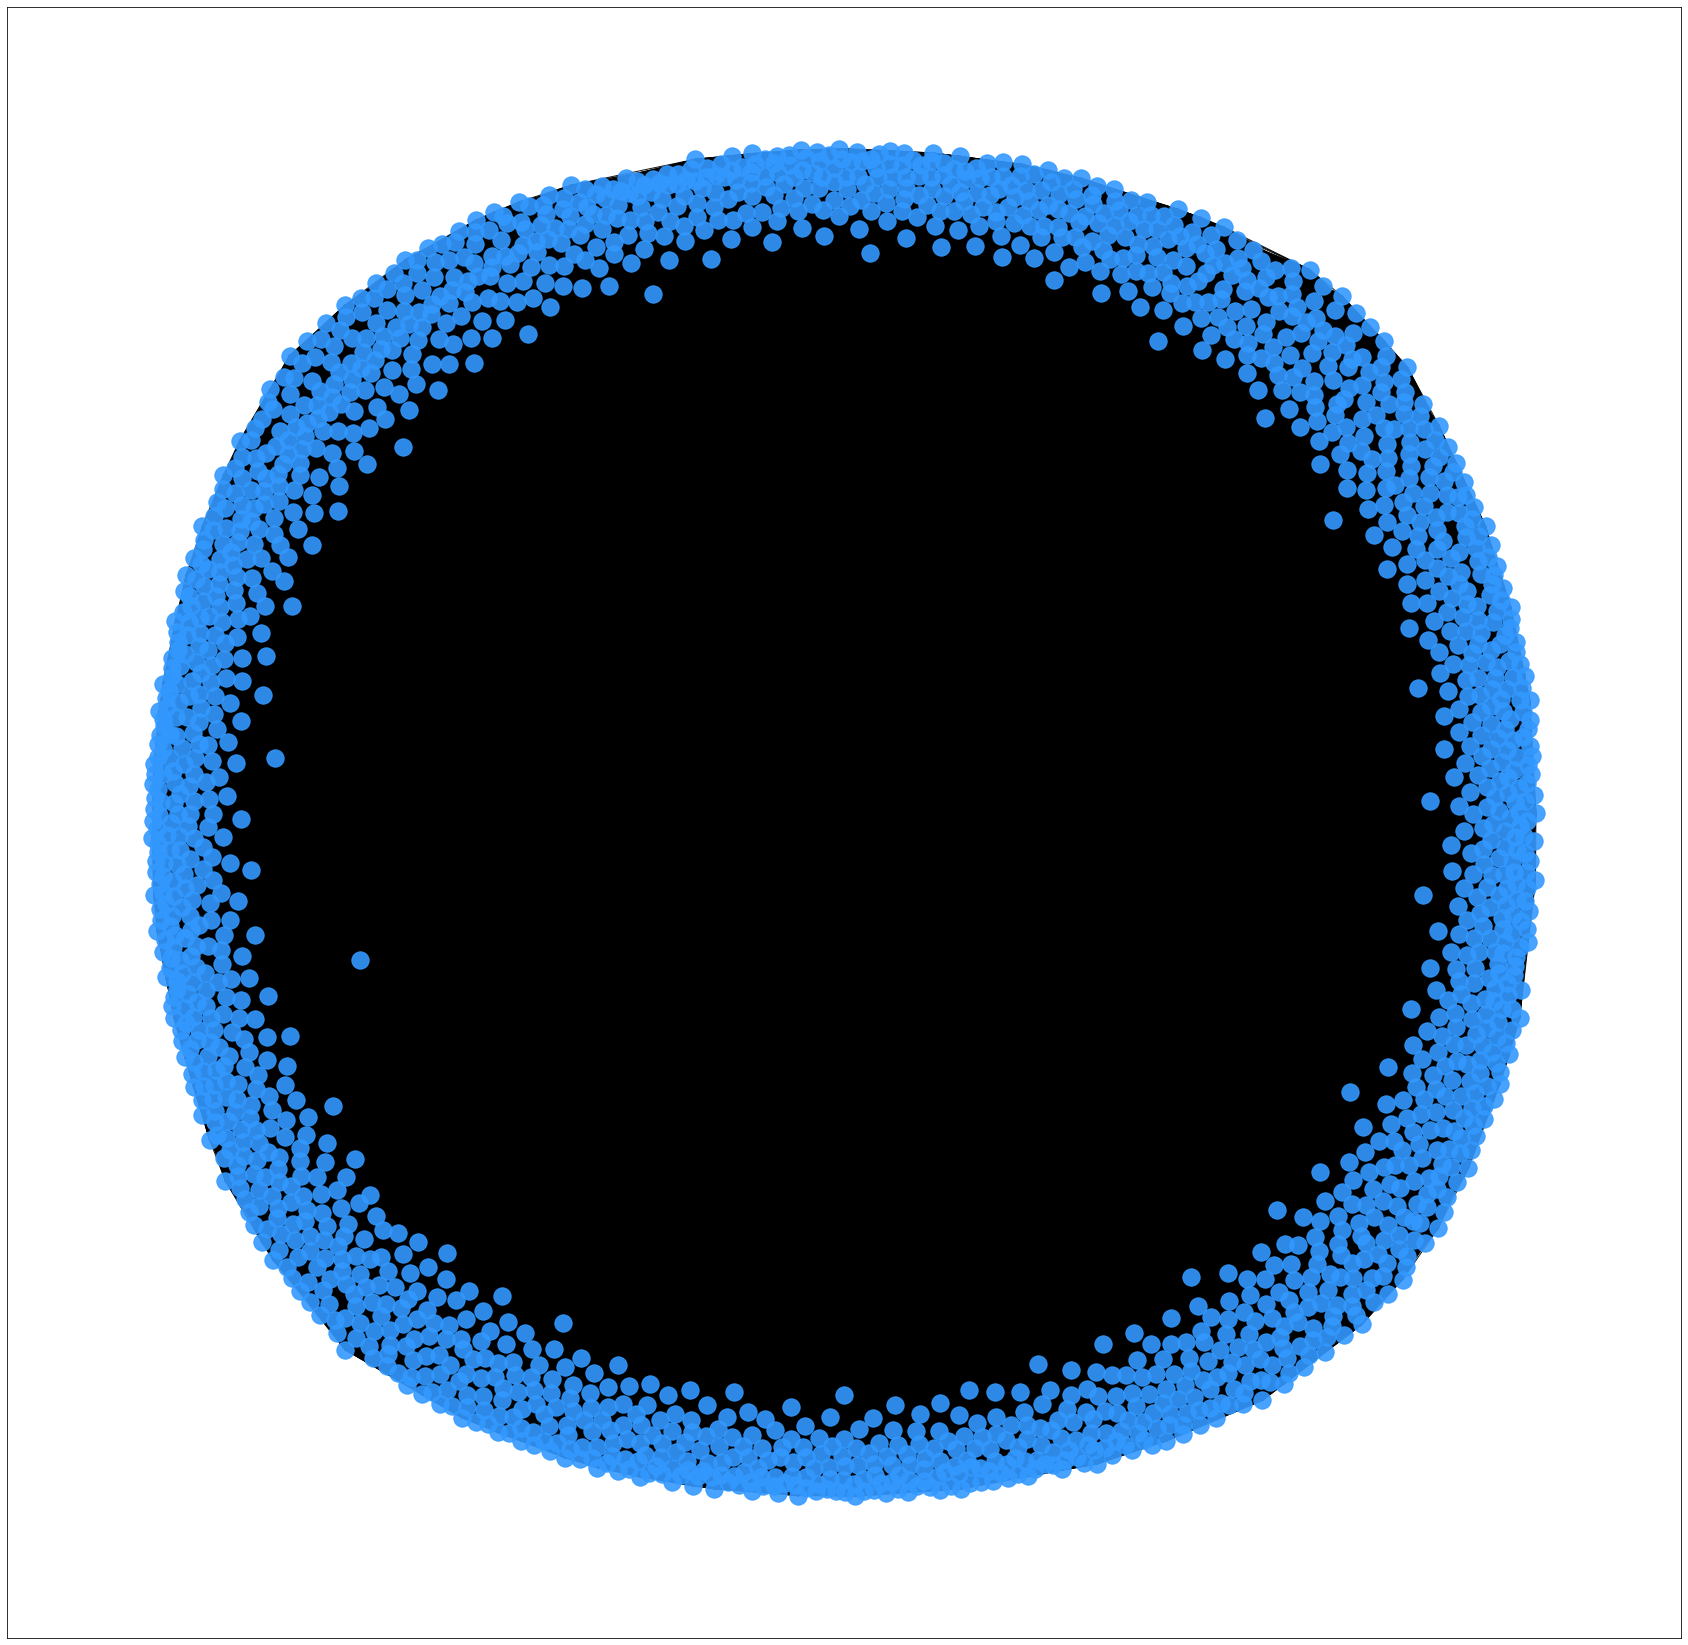

In [14]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(30,30))
nx.draw_networkx(clusterNetwork,nx.spring_layout(clusterNetwork,k=1),node_size=300,alpha = 0.9, node_color = '#3399ff',with_labels=False)
plt.show()

In [16]:
proteins = pd.read_csv("network_info/4932.protein.info.v11.5.txt", sep = "\t")
names = ['LPD1', 'PDA1', 'PYC2', 'PDB1', 'PTC1', 'BAT2', 'KGD1', 'AIM22', 'PKP1', 'PTC5', 'LAT1']
nodes = [] 
for name in names:
    nodes.append((proteins.loc[proteins['preferred_name'] == name])['#string_protein_id'].iloc[0])
print(nodes)

['4932.YFL018C', '4932.YER178W', '4932.YBR218C', '4932.YBR221C', '4932.YDL006W', '4932.YJR148W', '4932.YIL125W', '4932.YJL046W', '4932.YIL042C', '4932.YOR090C', '4932.YNL071W']
